# Demo change point detection

There are quite a few algorithms that you can use to determine the change point. Have a look at the PELT (Pruned Exact Linear Time) algorithm, Binary Segmentation, or Bayesian changepoint detection methods. Have a look at [Truong et al., 2020](https://arxiv.org/pdf/1801.00718.pdf) for in depth knowledge.

There are also some Python-packages available that take away the burden of creating this functionality yourself. The most used is [the `ruptures` package](https://pypi.org/project/ruptures/) (from that same Truong et al.), but you can also use [the `changefinder` package](https://pypi.org/project/changefinder/). Look at [this interesting blog by Tech Rando](https://techrando.com/2019/08/14/a-brief-introduction-to-change-point-detection-using-python/) for more information.

In this demo-notebook we are going to start with the implementation of one of the algorithms that are described in [Cabrieto et al, 2015](https://link.springer.com/article/10.3758/s13428-016-0754-9). Specifically, we will implement a simplified version of [the DeCon-algoritm](), using a sliding window over our dataset to identify outliers. 

For a more thorough analyses of the relation between change point detection and ECG-data, please refer to [Moeyersons et al., 2019](https://www.sciencedirect.com/science/article/pii/S0169260719312817).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')

## Create the sample data

In [21]:
mu1 = [1, 2, 3]
cov1 = [ [1,0,0], [0,1,0], [0,0,1] ]
mu2 = [3, 6, 9]
cov2 = [ [1, 0.9, 0.9], [0.9, 1, 0.9], [0.9, 0.9, 1] ]
data1 = np.random.multivariate_normal(mu1, cov1, size=(25,))
data2 = np.random.multivariate_normal(mu2, cov2, size=(25,))

In [22]:
data = np.append(data1, data2, axis=0)

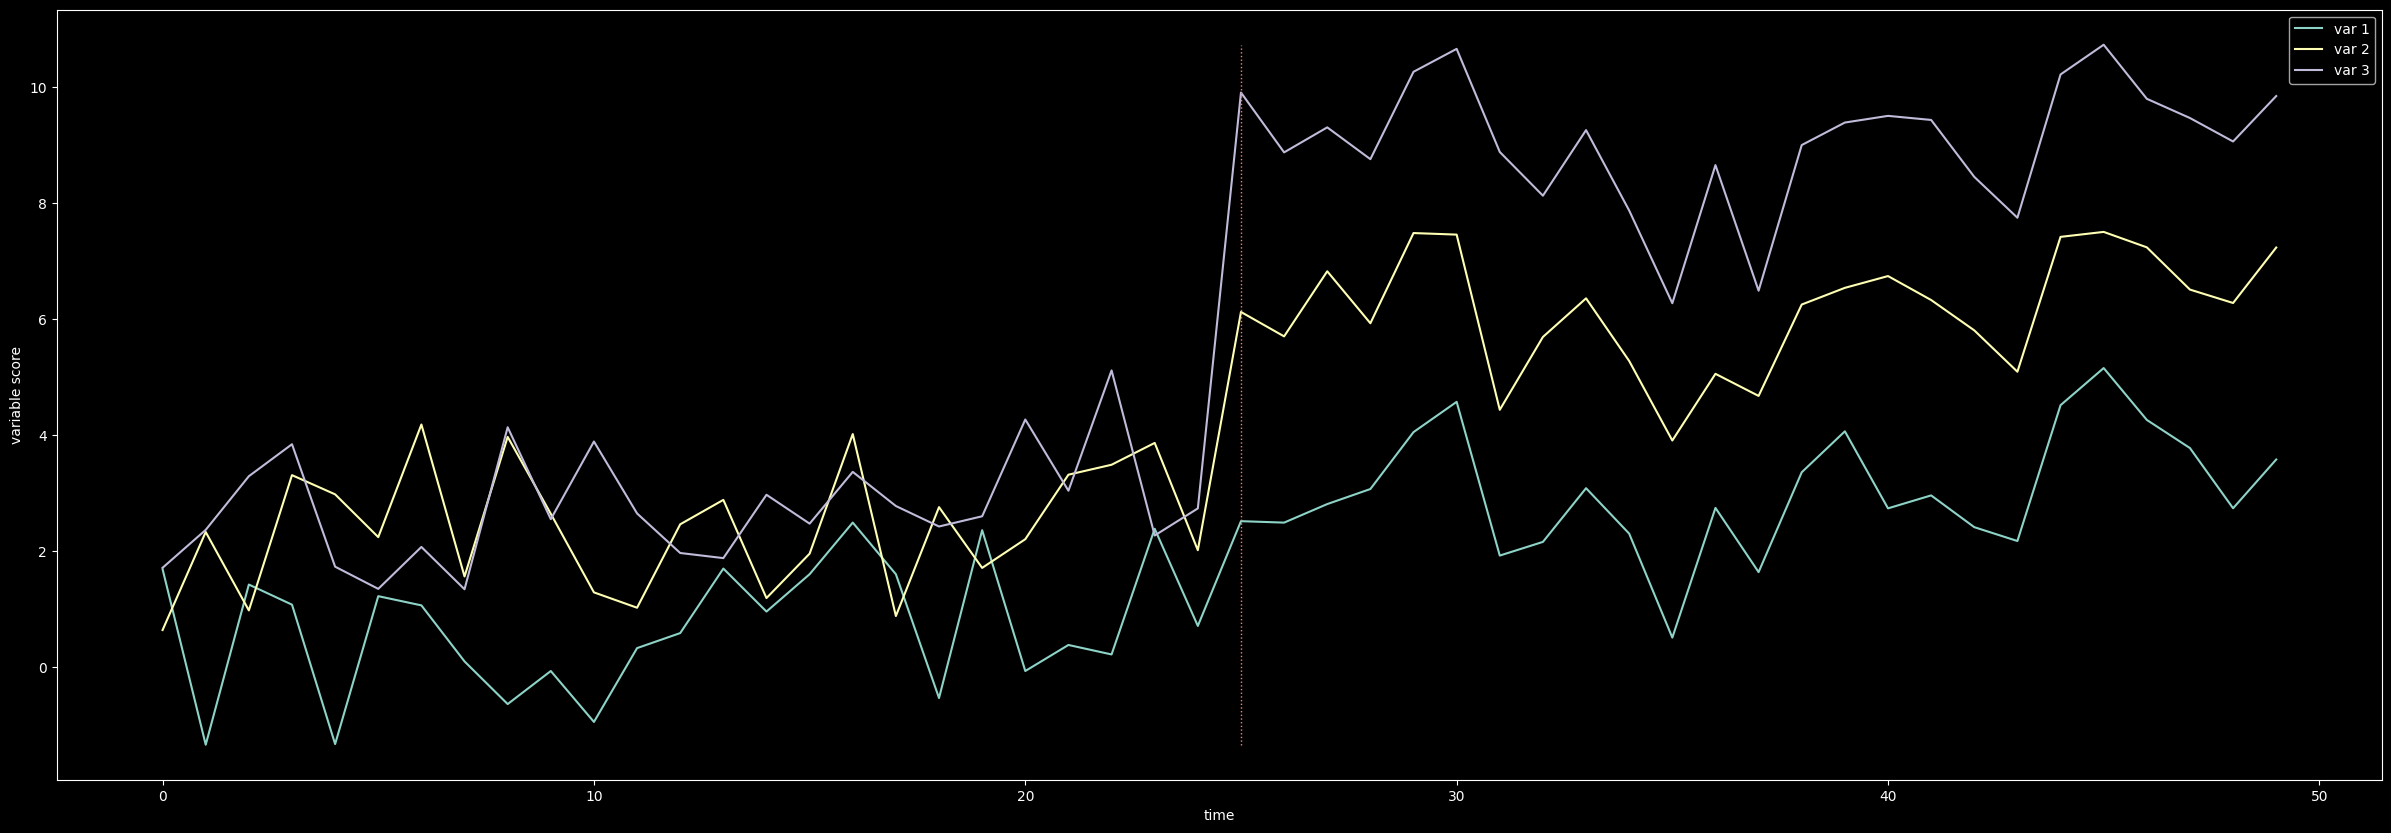

In [11]:
fig = plt.plot(data)
plt.rcParams['figure.figsize'] = (30,10)
plt.plot([25, 25], [np.min(data), np.max(data)], linestyle=':', linewidth=1)
plt.xlabel('time')
plt.ylabel('variable score')
plt.legend(iter(fig), ('var 1','var 2','var 3'))
plt.savefig('multivariate.png')


## DeCon

DeCon bases change point detection on outlier identification using robust statistics ([Bulteel et al., 2014](https://link.springer.com/article/10.3758/s13428-016-0754-9#ref-CR9)). The DeCon algorithm, short for Detection of Change in Signals using Deconvolution, is a method for detecting abrupt changes or change points in time series data. It is particularly useful when the data consists of a convolution of a smooth signal with an unknown kernel and noise.

The method slides a time window of size W across the time series by sequentially deleting the first time point in the window, and adding one new observation as the last time point. Per window, it is determined whether the last time point is an outlier with respect to the distribution of the other time points in the window. If the latter is the case for multiple consecutive windows, this signals that the observations that are added to the window might come from a different distribution, and, hence, that a change point occurred.

Specifically, DeCon consists of the following four steps.

1. Apply [Robust PCA](https://en.wikipedia.org/wiki/Robust_principal_component_analysis) in each time window and determine “outlyingness” of the last time point.
2. Track the moving sum of the outlyingness of ten subsequent last time points and declare a change point when this sum equals five at least.
3. Repeat steps 1 and 2 in the backward direction.
4. Combine change points detected in the forward and the backward procedure.


The following demonstration is just a start point for this algorithm. If you want to implement it completely, you could use [the sklearn implementation of PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) for the PCA. Or check [this implementation of Robus PCA](https://github.com/dganguli/robust-pca); have a look at [this discussion at StackOverflow](https://stackoverflow.com/a/42451260).

In this example we use the [Mahalanobis distance](https://en.wikipedia.org/wiki/Mahalanobis_distance) to determine the distance of point `x_last` from a distribution defined by `mu_w` and `cov_w`:

$$ MD(x) = \sqrt{ (x-\mu)^T \Sigma^{-1}(x-\mu)} $$

In [18]:
# Define the mahalanobis_distance
def mahalanobis_distance(x_last, mu_w, cov_w):
    return np.sqrt((x_last-mu_w).T.dot(np.linalg.inv(cov_w).dot(x_last - mu_w)))

# Check it with some known data
x_last = np.array( [1.08, 4.37, 7.36] )
u_w = np.array( [1.41, 1.89, 3.18] )
cov_w = np.array( ([0.29, -0.15, 0.11], [-0.15, 0.62, 0.13], [0.11, 0.13, 0.57]) )

# Should be around 6.06
mahalanobis_distance(x_last, u_w, cov_w)

6.062852612897912

In our example, we use a *window size* of twenty. Then we start at point 0 (so we have `data[:, 0:20]`) and continue until all data has been consumed.

In [23]:
w_size = 20 
i = 0
sd = [] # list to store the calculated score distances
while i+w_size < len(data):
    cov = np.cov(data.T[:, i:i+w_size])
    mu = np.mean(data.T[:, i:i+w_size], axis=1)
    dist = mahalanobis_distance(data[i+w_size-1], mu, cov)
    sd.append(dist)
    i += 1

Now we scatter the found score distances, adding the *window size* at the x-axis to make clear which was the index of the last time-point of our window.

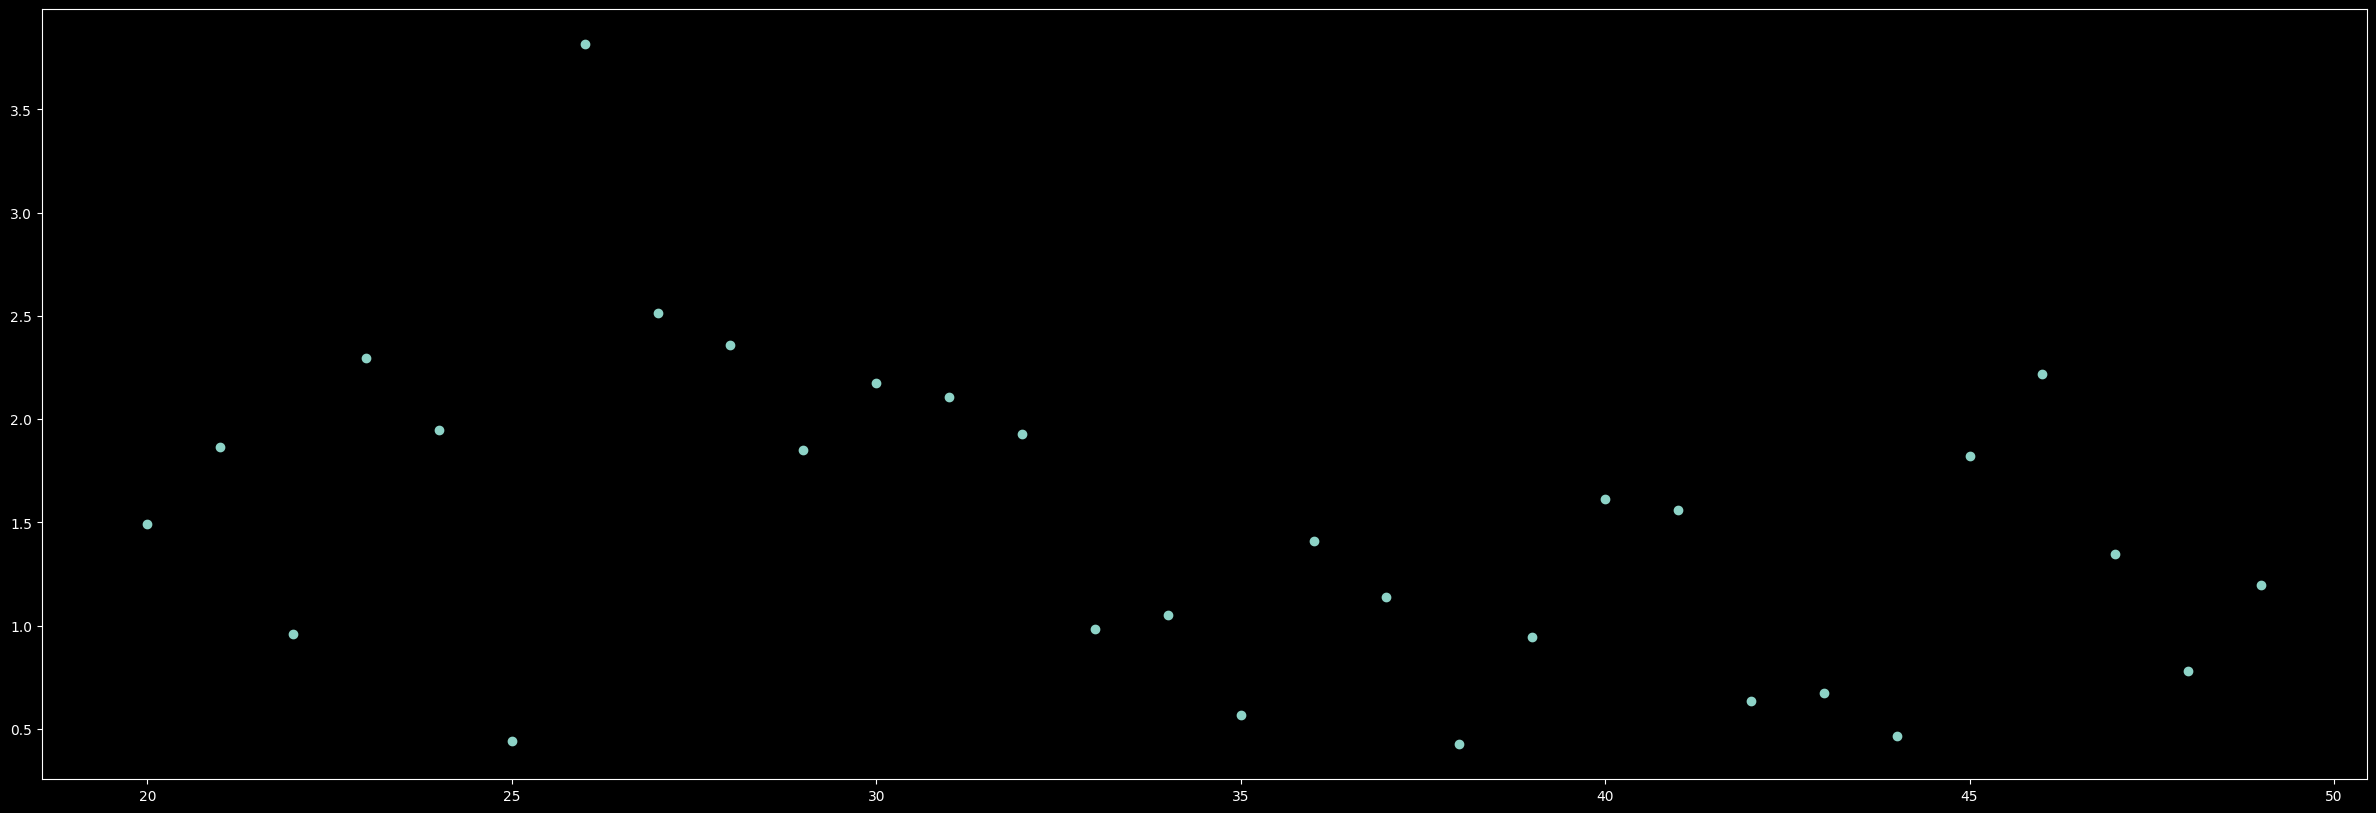

In [14]:
plt.scatter(np.arange(len(sd))+w_size, sd)

Now we need to determine which points within our set (the list `sd`) are actually outliers. In the following implementation we are using the IQR.

In [24]:
def outliers(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    return [i for i, x in enumerate(data) if x < lower_bound or x > upper_bound]

print (outliers(sd))


[6]


So we can conclude that the sixth element of our `sd` list is an outlier. That means that our change point is located at `6+window_size = 26`, which seems to be correct.